In [1]:
#Based on https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# Imports
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

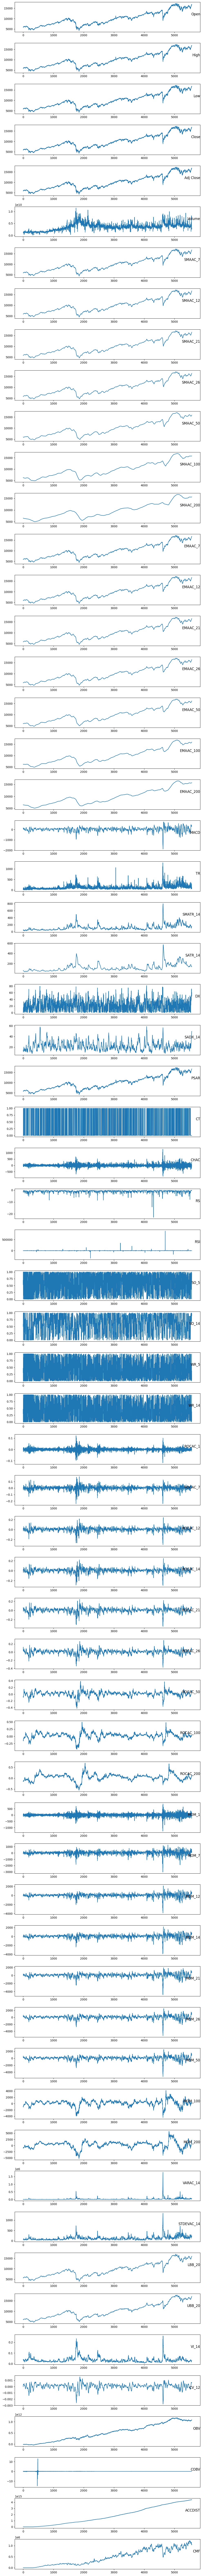

In [2]:
#Some plotting
from matplotlib import pyplot
# load dataset
dataset = read_csv('CSV Files with Calculated Indicators/NYSE.csv', header=0, index_col=0)
values = dataset.values

# Automatically determine the number of columns
num_columns = dataset.shape[1]  # This gets the number of columns in the DataFrame

pyplot.figure(figsize=(10, num_columns*2))  # Adjust the figure size as needed

# Plot each column
for i in range(num_columns):
    pyplot.subplot(num_columns, 1, i+1)  # Subplots are indexed from 1
    pyplot.plot(values[:, i])
    pyplot.title(dataset.columns[i], y=0.5, loc='right')

pyplot.tight_layout()  # Optional: Improves the layout
pyplot.show()

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
     cols.append(df.shift(i))
     names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
     cols.append(df.shift(-i))
 if i == 0:
     names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
 else:
     names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
     agg.dropna(inplace=True)
 return agg

In [4]:
# load dataset
dataset = read_csv('CSV Files with Calculated Indicators/NYSE.csv', header=0, index_col=0)
values = dataset.values

# Automatically determine the number of columns
num_columns = dataset.shape[1]  # This gets the number of columns in the DataFrame

ct_index = dataset.columns.get_loc("CT")
print(f"The index of the 'CT' column is: {ct_index}")

The index of the 'CT' column is: 27


In [5]:
# integer encode direction
encoder = LabelEncoder()
values[:,ct_index] = encoder.fit_transform(values[:,ct_index])

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_lag_periods = 3
n_features = num_columns
# frame as supervised learning
reframed = series_to_supervised(scaled, n_lag_periods, 1)
print(reframed.shape)

(5568, 252)


In [20]:
# split into train and test sets
values = reframed.values
n_train_period = int(0.9 * len(dataset))
train = values[:n_train_period, :]
test = values[n_train_period:, :]
# split into input and outputs

n_obs = n_lag_periods * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(5013, 189) 5013 (5013,)


In [21]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag_periods, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag_periods, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5013, 3, 63) (5013,) (555, 3, 63) (555,)


In [10]:
# design network

model = keras.layers.Input(shape=(train_X.shape[1], train_X.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(model)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=model, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()


# model = Sequential()

# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')
# model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 3, 63)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 3, 150)              │         128,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 150)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 3, 150)              │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 150)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 150)                 │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 489,751 (1.87 MB)

 Trainable params: 489,751 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0080 - val_loss: 0.0221
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0497 - val_loss: 0.0050
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0174 - val_loss: 0.0035
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.1126e-04 - val_loss: 0.0118
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.8001e-04 - val_loss: 0.0143
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0016 - val_loss: 0.0078
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.7512e-04 - val_loss: 0.0086
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.4017e-04 - val_loss: 0.0047
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.9687e-04 - val_loss: 0.0158
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 2

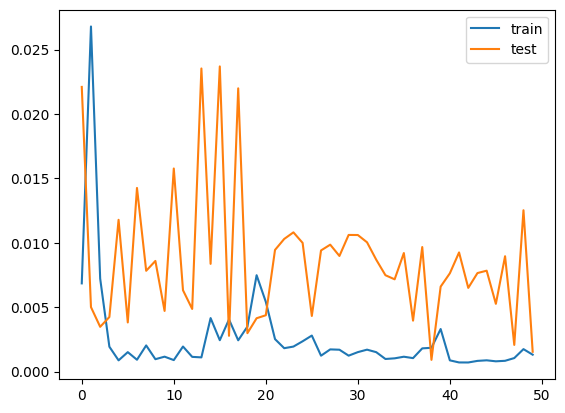

In [11]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [24]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_lag_periods*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -n_features:]), axis=1)
inv_yhat = inv_yhat.reshape((inv_yhat.shape[0], n_lag_periods * n_features))
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


ValueError: cannot reshape array of size 35520 into shape (555,189)